<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 63134054, 'trade_mode': 2, 'leverage': 200, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 50.12, 'credit': 13.06, 'profit': 0.0, 'equity': 63.18, 'margin': 0.0, 'margin_free': 63.18, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'Bright Idowu ', 'server': 'OctaFX-Real', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': False, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last': 1988

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

63.18
AI is successfully functional


In [ ]:
t_s = "BTCUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
#display(market)
print(market.shape)

print(t_s)




(722728,)
BTCUSD


In [ ]:
market

array([(1311242400, 1.3690000e+01, 1.378000e+01, 1.340000e+01, 1.361000e+01,   69,    0, 0),
       (1311328800, 1.3610000e+01, 1.381000e+01, 1.345000e+01, 1.370000e+01,   64,    0, 0),
       (1311415200, 1.3700000e+01, 1.376000e+01, 1.351000e+01, 1.368000e+01,   49,    0, 0),
       ...,
       (1762898100, 1.0328383e+05, 1.033055e+05, 1.030590e+05, 1.030890e+05, 1725, 2520, 0),
       (1762898400, 1.0309000e+05, 1.030945e+05, 1.029350e+05, 1.030000e+05, 1793, 2527, 0),
       (1762898700, 1.0299400e+05, 1.030400e+05, 1.028489e+05, 1.028655e+05, 1276, 2521, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [ ]:
data = []
for i in range(len(market)):
    data.append([market[i][0],market[i][1],market[i][2],market[i][3],market[i][4],market[i][5]])
df = pd.DataFrame(data, columns=["time","open", "high","low", "close","volume"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import math

In [5]:
window_size = 60         # length of input sequence for model (e.g., 60 timesteps)
lookahead = 3            # how many future closes to check to form the label
threshold = 0.0015       # minimal relative move (e.g., 0.15%) to consider up/down (set 0 to disable)
train_frac = 0.7         # chronological split: train | val | test
val_frac = 0.15
test_frac = 0.15

In [6]:
t_symbol = ["GBPUSD"]

In [7]:


def engineer_features(df):
    df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
    df['month'] = df['time'].dt.month

    # Extract day of the month (1-31)
    df['day'] = df['time'].dt.day


    # --- New Additions ---
    # Extract hour (0-23)
    #df['hour'] = df['time'].dt.hour

    # Extract minute (0-59)
    #df['minute'] = df['time'].dt.minute



    # --- End of New Additions ---

    # 3. Remove the original 'time' column
    df = df.drop(columns=['time'])
    # --- Clean up and drop NaNs (first ~200 rows) ---
    df = df.dropna().reset_index(drop=True)

    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [8]:
n = 0
m_label = "Generated"+t_symbol[n]
#pd.set_option('display.float_format', '{:.20f}'.format)

train_df = pd.read_csv(m_label+ " dbot.csv")[['time','close','spread','volume']]
train_df = engineer_features(train_df)
train_df

,close,spread,volume,month,day
0,1.53380,50,2781,5,12
1,1.52250,50,2571,5,13
2,1.53870,50,2711,5,14
3,1.53550,50,2921,5,17
4,1.53650,50,2711,5,18
...,...,...,...,...,...
1985190,1.31742,14,667,11,13
1985191,1.31734,14,562,11,13
1985192,1.31653,14,588,11,13
1985193,1.31687,14,636,11,13


In [9]:


max_val = train_df.max()
joblib.dump(max_val,m_label+" max_val.joblib")
print(max_val)
train_df = train_df/max_val
#train_df = engineer_features_5min_btc(train_df)[10:]

close         2.116
spread      457.000
volume    39094.000
month        12.000
day          31.000
dtype: float64


In [10]:
train_df

,close,spread,volume,month,day
0,0.724858,0.109409,0.071136,0.416667,0.387097
1,0.719518,0.109409,0.065765,0.416667,0.419355
2,0.727174,0.109409,0.069346,0.416667,0.451613
3,0.725662,0.109409,0.074717,0.416667,0.548387
4,0.726134,0.109409,0.069346,0.416667,0.580645
...,...,...,...,...,...
1985190,0.622599,0.030635,0.017061,0.916667,0.419355
1985191,0.622561,0.030635,0.014376,0.916667,0.419355
1985192,0.622179,0.030635,0.015041,0.916667,0.419355
1985193,0.622339,0.030635,0.016268,0.916667,0.419355


In [11]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 50 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape


X, y = create_sequences(train_df.values, SEQ_LEN, 2, 0 )
train_df = None
n_samples = X.shape[0]
#print(X[-1])
print(y[-1])

GeneratedGBPUSD
[0.62233932 0.62227316]


In [12]:
# -----------------------
# Chronological split: train / val / test
# -----------------------
import math
n = len(X)
train_end = int(math.floor(n * train_frac))
val_end = train_end + int(math.floor(n * val_frac))

X_train = X[:train_end]
y_train = y[:train_end]
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
X_test = X[val_end:]
y_test = y[val_end:]

X = None
y = None

In [13]:

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))

X = Bidirectional(LSTM(64, return_sequences=True))(i)
X = Dropout(0.25)(X)
X = Bidirectional(LSTM(64, return_sequences=True))(X)
X = Dropout(0.25)(X)
X = Bidirectional(LSTM(64))(X)
X = Dense(64)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,858 (944.76 KB)

 Trainable params: 241,858 (944.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=4096,
  callbacks=[es, rlr, mc ],
  verbose=1

)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.0202 - mae: 0.0716 - mape: 9.4052 - msle: 0.0084 - root_mean_squared_error: 0.1201
Epoch 1: val_loss improved from inf to 0.00001, saving model to GeneratedGBPUSDlstm_best.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 112s 307ms/step - loss: 0.0202 - mae: 0.0715 - mape: 9.3901 - msle: 0.0083 - root_mean_squared_error: 0.1199 - val_loss: 1.3414e-05 - val_mae: 0.0030 - val_mape: 0.4845 - val_msle: 5.0682e-06 - val_root_mean_squared_error: 0.0037 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 2.8720e-04 - mae: 0.0134 - mape: 1.7590 - msle: 9.1501e-05 - root_mean_squared_error: 0.0169
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to GeneratedGBPUSDlstm_best.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 103s 304ms/step - loss: 2.8707e-04 - mae: 0.0134 - mape: 1.7586 - msle: 9.1459e-05 - root_mean_squared_error: 0.0169 - val_loss: 1.1880e-05 - val_mae: 0.0027 - val_mape: 0.4430 - val_msle: 4

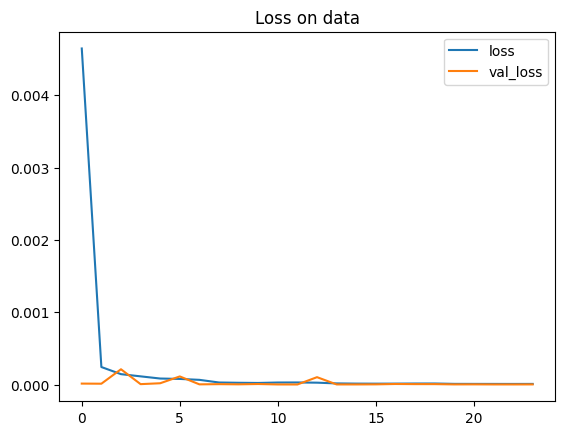

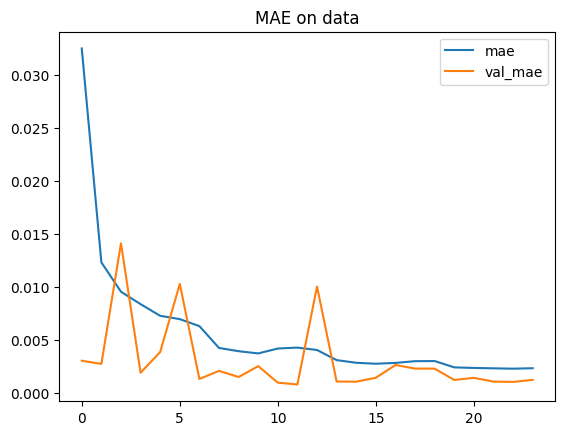

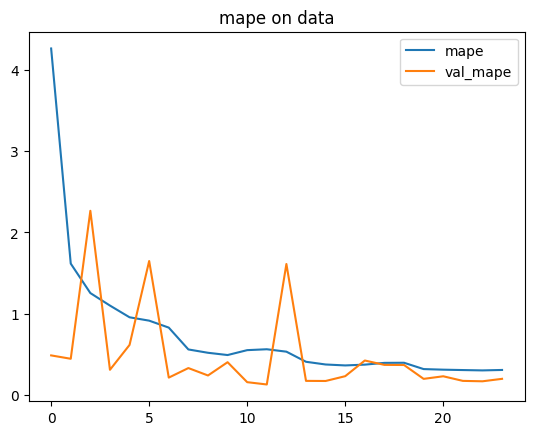

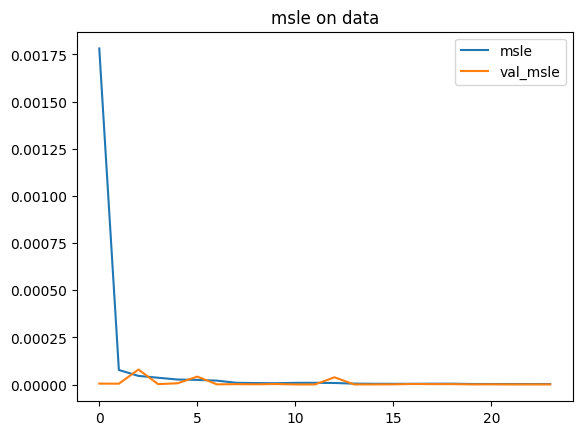

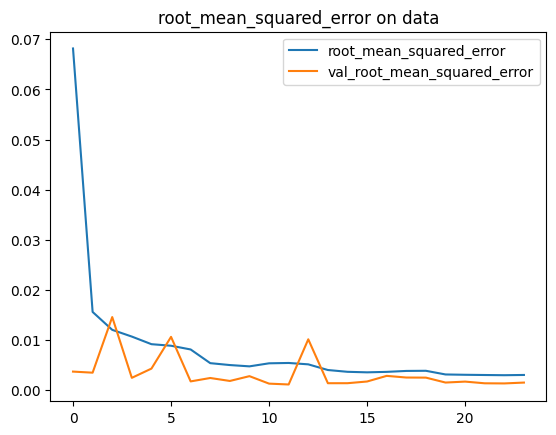

In [15]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [16]:
m_label = "GeneratedGBPUSD"
best_model = load_model(m_label + 'lstm_best.keras')

In [17]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,576 (2.77 MB)

 Trainable params: 241,858 (944.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 483,718 (1.85 MB)

In [18]:
y_pred = best_model.predict(X_test)

9306/9306 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step


In [19]:
print(y_pred.shape)

(297773, 2)


In [20]:
#_,y_test = inverse_transform_data(scaled_y=y_test)
#_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[0.63791588 0.63797259]
 [0.63797259 0.63786862]
 [0.63786862 0.63752363]
 ...
 [0.62256144 0.62217864]
 [0.62217864 0.62233932]
 [0.62233932 0.62227316]]  comparing to  [[0.6381077  0.63772225]
 [0.63812745 0.6377391 ]
 [0.6381404  0.63774693]
 ...
 [0.62258404 0.62197965]
 [0.62259614 0.62199503]
 [0.62260616 0.622018  ]]


In [21]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")



Average Gap (Bias): 0.0003417

--- Example of Correction ---
Original Prediction: 0.6381077
Corrected Prediction: 0.6384494
Actual Value:        0.6379159


In [22]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))
print(r2_score(y_test, y_pred_corrected))

R^2 value for  GeneratedGBPUSD
0.9971756133504568
0.9973390466225762


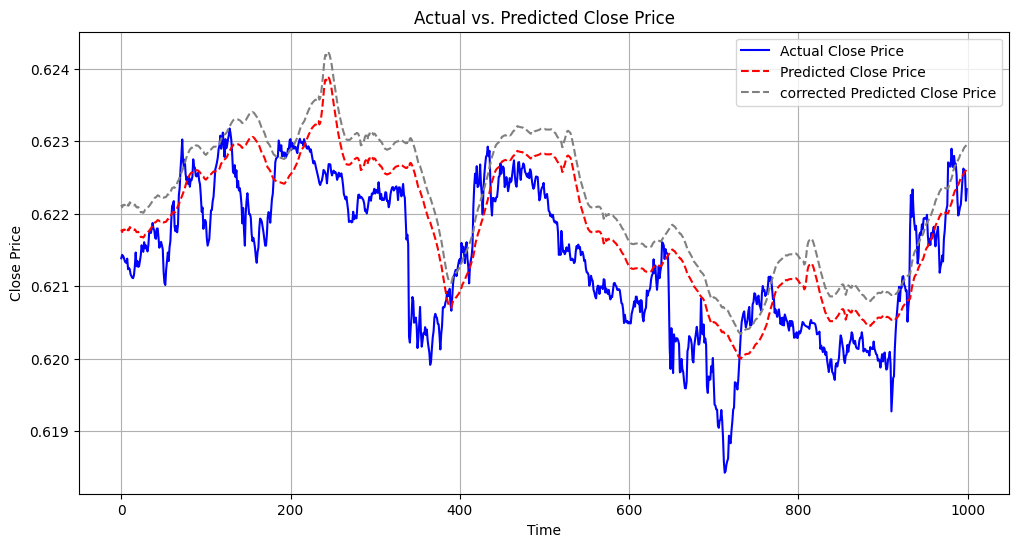

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[-1000:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[-1000:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[-1000:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()


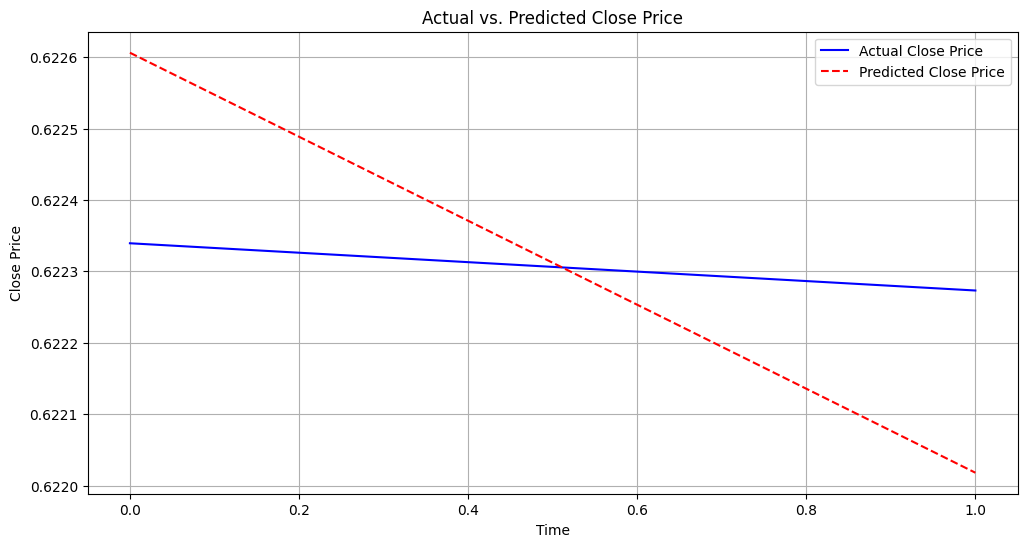

In [24]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[-1, :], label='Actual Close Price', color='blue')
plt.plot(y_pred[-1, :], label='Predicted Close Price', color='red', linestyle='--')
#plt.plot(y_pred_corrected[0, :], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()